In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pulp import *
from copy import deepcopy
while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.parser import Parser
from src.preprocessing.preprocessor import Preprocessor
from src.solvers.solution import Solution
from src.solvers.greedy import GreedySolver
from src.solvers.pulp_solver import PuLPSolver
from src.solvers.dp import DPSolver
from src.solvers.base_solver import DPMethods

from time import time
from tqdm import tqdm
from typing import Dict

/tmp/ipykernel_150626/2326566885.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
def get_num_triples(dataset : Dict):
    num_triples= 0
    for n in dataset.keys():
        num_triples += len(dataset[n])
    
    return num_triples

## Test 02

In [5]:
parser = Parser("data/testfiles/test2.txt")

In [6]:
t0 = time()
info = parser.read()
t1 = time()

print(f"Total execution time {t1 - t0} s")

28it [00:00, 157638.27it/s]

Total execution time 0.0240631103515625 s


In [7]:
dataset : Dict[int, pd.DataFrame ]= info['data']
p, K, M, N = info['p'], info['K'], info['M'], info['N']

In [8]:
preprocessing_results = {}
preprocessing_results['initial data'] = {
    "runtime": 0,
    "num_triples": get_num_triples(dataset)
}
preprocessor = Preprocessor(
    K, 
    M,
    N,
    p,
    dataset
)

t0 = time()

data_1 = preprocessor.remove_trivial_values()
t1 = time()

preprocessing_results['remove trivial values'] = {
    "runtime": (t1 - t0),
    "num_triples": get_num_triples(data_1)
}
t1 = time()

data_2 = preprocessor.remove_ip_dominated(data_1)
t2 = time()
preprocessing_results['remove IP dominated'] = {
    "runtime": t2-t1,
    "num_triples": get_num_triples(data_2)
}
t2 = time()

data_3 = preprocessor.remove_lp_dominated(data_2)
t3 = time()
preprocessing_results['remove LP dominated'] = {
    "runtime": t3-t2,
    "num_triples": get_num_triples(data_3)
}


  0%|          | 0/4 [00:00<?, ?it/s]


/home/pedro/Desktop/Polytechnique/user-scheduling-in-5G/src/preprocessing/preprocessor.py:24: SyntaxWarning: invalid escape sequence '\s'
  """Remove unfeasible triplets k,m,n such that


KeyError: 0

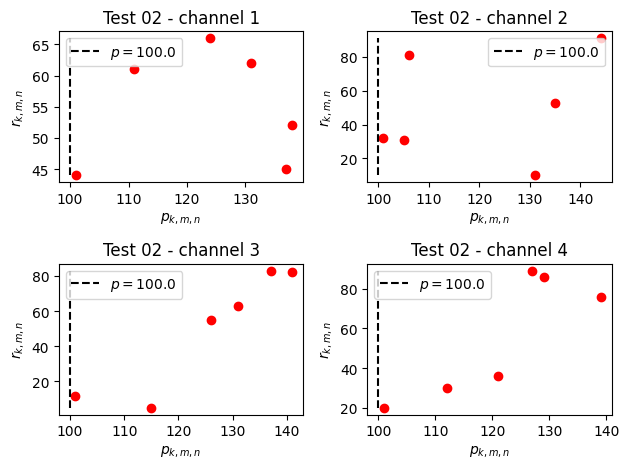

In [32]:
channel_number = 0

# Creating a figure with 4 subplots
fig, axs = plt.subplots(2, 2)

# Plotting on each subplot
for i in range(2):
    for j in range(2):

        channel_number = 2*i + j
        axs[i, j].scatter(
            dataset[channel_number]['p_k,m,n'],
            dataset[channel_number]['r_k,m,n'],
            # label = "pairs",
            color = "red"
        )
        axs[i,j].set_title(f'Test 02 - channel {channel_number + 1}')

        axs[i,j].vlines(
            p,
            dataset[channel_number]['r_k,m,n'].min(),
            dataset[channel_number]['r_k,m,n'].max(),
            color = "black",
            linestyles = "dashed",
            label = rf"$p = {p}$"
        )

        axs[i,j].legend()
        axs[i,j].set_xlabel(r"$p_{k,m,n}$")
        axs[i,j].set_ylabel(r"$r_{k,m,n}$")

# plt.scatter(
#     dataset[channel_number]['p_k,m,n'],
#     dataset[channel_number]['r_k,m,n'],
#     label= "unfeasible pairs (p,r)",
#     color = "red"
# )

plt.tight_layout()
plt.savefig("img/test02-no_feasible_solution.png")
plt.show()

In [10]:
pd.DataFrame(preprocessing_results)

,initial data,remove trivial values,remove IP dominated
runtime,0,0.022447,0.004132
num_triples,24,0.000000,0.000000


## Greedy algorithm

In [ ]:
lp_results = {}

In [ ]:
pulp_solver = PuLPSolver(
    K, 
    M,
    N,
    p,
    data_3
)
pulp_solver.set_problem(data_3)

t1 = time()
pulp_solver.solve()
t2 = time()

lp_results['pulp'] = {
    'runtime': t2-t1,
    'data_rate' : pulp_solver.solution.objective.value()
}

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/pedro/anaconda3/envs/user-scheduling-in-5g/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/72a46fb0bc4f4d2b937cbd2bdbb3a48f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/72a46fb0bc4f4d2b937cbd2bdbb3a48f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 41 RHS
At line 47 BOUNDS
At line 58 ENDATA
Problem MODEL has 5 rows, 10 columns and 20 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
0  Obj -0 Primal inf 3.9999996 (4) Dual inf 579 (10)
6  Obj -2871.2 Primal inf 121.6 (2)
Primal infeasible - objective value -2871.2
PrimalInfeasible objective -2871.2 - 6 iterations time 0.002

Result - Linear relaxation infeasible

Enumerated no

In [ ]:
solver = GreedySolver(
    K, 
    M,
    N,
    p,
    data_3
)

t1 = time()
solver.solve(data_3)
t2 = time()

lp_results['greedy'] = {
    'runtime': t2-t1,
    'data_rate' : solver.solution.get_data_rate()
}


ValueError: You can only consume at most the power you have available. Tryed to consume 101.0 but have only 100.0 available

In [ ]:
pd.DataFrame(lp_results)

,greedy,pulp
runtime,0.009554,0.005116
data_rate,365.000000,365.000000


## Solutions to the ILP

In [ ]:
dp_solver = DPSolver(
    K, 
    M,
    N,
    p,
    data_3
)

t1 = time()
dp_solver.solve(
    None,
    method = DPMethods.MAXIMIZE_R
)
t2 = time()
ilp_results['DP_maximize_r'] = {
    'runtime' : t2 - t1,
    "data_rate" : dp_solver.solution.get_data_rate()
}

pulp_solver.solve()
U = int(pulp_solver.solution.objective.value())

t1 = time()
dp_solver.solve(
    None,
    method = DPMethods.MINIMIZE_P,
    U = U
)
t2 = time()

ilp_results['DP_minimize_p'] = {
    'runtime' : t2 - t1,
    "data_rate" : dp_solver.solution.get_data_rate()
}

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/pedro/anaconda3/envs/user-scheduling-in-5g/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5270027464e24cd984a384939cce6188-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/5270027464e24cd984a384939cce6188-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 35 RHS
At line 41 BOUNDS
At line 50 ENDATA
Problem MODEL has 5 rows, 8 columns and 16 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-5) rows, 0 (-8) columns and 0 (-16) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 365
After Postsolve, objective 365, infeasibilities - dual 191 (4), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj 365 Dual inf 234.9072 (4)
4  Obj 365
Optimal - objective value 365
Optimal objective 365 - 4 i